<a href="https://colab.research.google.com/github/megha-66/Deep-Learning-Lab-works-/blob/main/dl_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt


In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


In [ ]:
n_samples, h, w = lfw_people.images.shape
n_features = lfw_people.data.shape[1]
n_classes = len(lfw_people.target_names)

In [ ]:
print(f"Number of samples: {n_samples}")
print(f"Image dimensions (height x width): {h} x {w}")
print(f"Number of features: {n_features}")
print(f"Number of unique classes/people: {n_classes}")
print(f"Class names: {lfw_people.target_names}")


Number of samples: 1288
Image dimensions (height x width): 50 x 37
Number of features: 1850
Number of unique classes/people: 7
Class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


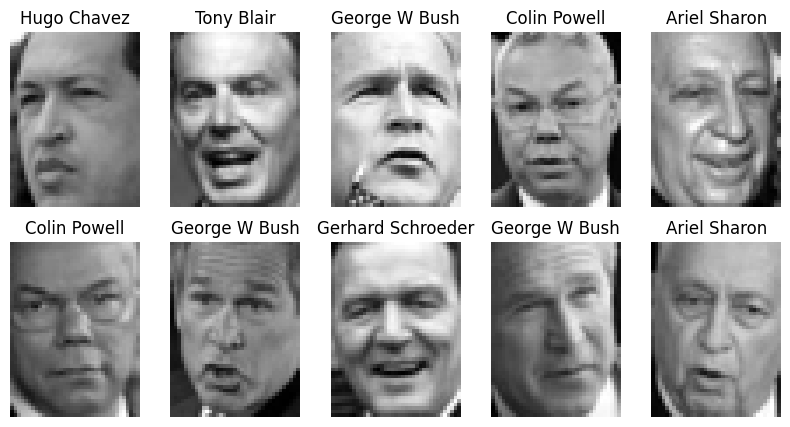

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw_people.images[i], cmap='gray')
    ax.set_title(lfw_people.target_names[lfw_people.target[i]])
    ax.axis('off')
plt.show()

In [ ]:
print(f"Original Min pixel value: {np.min(lfw_people.images)}")
print(f"Original Max pixel value: {np.max(lfw_people.images)}")


Original Min pixel value: 0.0
Original Max pixel value: 1.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models, Input

In [ ]:
x = lfw_people.images
y = lfw_people.target
class_names = lfw_people.target_names

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
def create_triplets(x, y):
    num_classes = len(np.unique(y))
    triplets = []

    for i in range(len(x)):
        anchor_image = x[i]
        anchor_label = y[i]

        # Positive sample
        positive_indices = np.where(y == anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]  # Remove the anchor itself
        if len(positive_indices) == 0:
            continue  # Skip if no positive samples are found
        positive_image = x[np.random.choice(positive_indices)]

        # Negative sample
        negative_label = np.random.choice(np.setdiff1d(np.unique(y), anchor_label))
        negative_indices = np.where(y == negative_label)[0]
        if len(negative_indices) == 0:
            continue
        negative_image = x[np.random.choice(negative_indices)]

        triplets.append((anchor_image, positive_image, negative_image))

    return np.array(triplets)

In [ ]:
triplets_train = create_triplets(X_train, y_train)
anchor_data = np.array([t[0] for t in triplets_train])
positive_data = np.array([t[1] for t in triplets_train])
negative_data = np.array([t[2] for t in triplets_train])

In [ ]:
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalization for embeddings
    ])

    return model

In [ ]:
import tensorflow as tf

class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0, **kwargs):
        super(TripletLoss, self).__init__(**kwargs)
        self.margin = margin

    def call(self, y_true, y_pred):
        anchor_embedding, positive_embedding, negative_embedding = y_pred

        # Calculate pairwise distances
        pos_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
        neg_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)

        # Compute triplet loss
        loss = tf.maximum(pos_distance - neg_distance + self.margin, 0.0)
        return tf.reduce_mean(loss)


In [ ]:
inputshape = (50, 37, 1)
cnnmodel = build_cnn_model(inputshape)

In [ ]:
anchor_input = Input(shape=inputshape, name="anchor_input")
positive_input = Input(shape=inputshape, name="positive_input")
negative_input = Input(shape=inputshape, name="negative_input")


In [ ]:
anchor_embedding = cnnmodel(anchor_input)
positive_embedding = cnnmodel(positive_input)
negative_embedding = cnnmodel(negative_input)


In [ ]:
siamese_network = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input],
                               outputs=[anchor_embedding, positive_embedding, negative_embedding])

In [ ]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

triplet_loss_fn = TripletLoss(margin=1.0)

# Compile the model with the triplet loss function
siamese_network.compile(optimizer=optimizer, loss=triplet_loss_fn)


In [ ]:
def create_tf_dataset(anchor_data, positive_data, negative_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(((anchor_data, positive_data, negative_data),
                                                 (anchor_data, positive_data, negative_data)))
    dataset = dataset.shuffle(buffer_size=10000).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_tf_dataset(anchor_data, positive_data, negative_data, 16)

In [ ]:
train_dataset = create_tf_dataset(anchor_data, positive_data, negative_data, 16)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3)


In [ ]:
history = siamese_network.fit(train_dataset,

                              epochs=2,
                              callbacks=[early_stopping])

Epoch 1/2


OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.

In [ ]:
siamese_network.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 50, 37, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 50, 37, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 50, 37, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 256)       │  1,814,784 │ anchor_input[0][… │
│ (Sequential)        │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,814,784 (6.92 MB)

 Trainable params: 1,814,784 (6.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f"Anchor data shape: {anchor_data.shape}")
print(f"Positive data shape: {positive_data.shape}")
print(f"Negative data shape: {negative_data.shape}")

Anchor data shape: (901, 50, 37)
Positive data shape: (901, 50, 37)
Negative data shape: (901, 50, 37)
